**TEXT CLASSIFICATION MODEL ON CHAT MESSAGES DATASET**

**OBJECTIVE:**

The main objective of this project is building a text classification model using the Chat Messages dataset. The main goal is to develop 4 classes representing Positive,Negative,Neutral and Abusive sentiments.

**ABOUT THE DATASET**

We will be using the state-of-the-art Chat Messages Sentiment Datasets available on https://www.kaggle.com/datasets/nursyahrina/chat-sentiment-dataset
The dataset contains 500+ chat messages with their corresponding sentiment labels.

**IMPORTING THE LIBRARIES**

In [1]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from sklearn.feature_extraction.text import TfidfVectorizer
import re
from sklearn import metrics
from sklearn.metrics import confusion_matrix,classification_report
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize, pos_tag


In [2]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\awans\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

**LOADING THE DATASET**

In [3]:
df=pd.read_csv('chat sentiments.csv')

In [4]:
df.head(5)

,message,sentiment
0,I really enjoyed the movie,positive
1,The food was terrible,negative
2,I'm not sure how I feel about this,neutral
3,The service was excellent,positive
4,I had a bad experience,negative


In [5]:
df.shape

(584, 2)

In [6]:
df['sentiment'].value_counts()

sentiment
neutral     259
positive    178
negative    147
Name: count, dtype: int64

In [7]:
df.isna().sum()

message      0
sentiment    0
dtype: int64

**EXTRACTING SPECIAL CHARACTERS**

In [8]:
df.columns

Index(['message', 'sentiment'], dtype='object')

In [9]:
df.rename(columns={'message':'review'},inplace=True)


In [10]:
df.columns

Index(['review', 'sentiment'], dtype='object')

In [11]:

def extract_special(text):
    pattern=re.compile('[^A-Za-z0-9\s]')
    special=pattern.findall(text)
    return special

df['special']=df['review'].apply(extract_special)
all_special_chars = [char for sublist in df['special'] for char in sublist]
print(set(all_special_chars))

df.drop('special',axis=1)

{'😱', '📅', '🎥', '🎉', '🧺', '😬', '🎁', '😩', '🌅', '👧', '🖥', '🏡', '📈', '🤘', '🐱', '😴', '🍞', '😔', '🍿', '💰', '😭', '🙄', '💇', '💡', '🎊', '🌟', '😞', '/', '😠', '🤧', '📆', '🤒', '!', '💸', '🧢', '🍣', '☀', '💳', '🏠', '🧹', '💕', '🤓', '👩', '🛫', '🙌', '☕', '📝', '🗺', '🇹', '👨', '❤', '👞', '🎶', '🔮', '🍔', '🥗', '🚗', '🎨', '👌', '🤢', '🚶', '🏥', '🍂', '🥱', '😒', '🌞', '📉', '😰', '😃', '🎓', '📞', '😐', '✨', '🧳', '🎢', '.', '🚣', '👦', '🤔', '🎤', '🍀', '😍', '🛋', '⚖', '🌻', '😫', '😌', '🌳', '🔍', '🛍', '🏞', '🤨', '📱', '🌴', '🏋', '🤷', '♂', '🏆', '🏖', '🕺', '🤦', '😢', '😊', '🌎', '😕', '🏃', '📚', '🙏', '😀', '🍴', '🐶', '🌧', '🌪', '🤗', '🥰', '🗓', '-', '🙈', '?', '🌊', '🤬', '😤', '💼', '🕑', '$', '🦷', '💦', '️', '💔', '♀', '🇮', '😓', '💑', '😎', '🍊', '🌱', '👗', '🍻', '💪', '💻', '😋', '😟', '🧐', '🎫', '😷', '🥇', '👕', '🤫', '👋', '🏅', '🍽', "'", '⛰', '🛀', '🤯', '🧘', '🎠', ':', '👍', '🎯', '\u200d', '🤩'}


<>:2: SyntaxWarning: invalid escape sequence '\s'
<>:2: SyntaxWarning: invalid escape sequence '\s'
C:\Users\awans\AppData\Local\Temp\ipykernel_11464\2915979600.py:2: SyntaxWarning: invalid escape sequence '\s'
  pattern=re.compile('[^A-Za-z0-9\s]')


,review,sentiment
0,I really enjoyed the movie,positive
1,The food was terrible,negative
2,I'm not sure how I feel about this,neutral
3,The service was excellent,positive
4,I had a bad experience,negative
...,...,...
579,I have to cancel my vacation plans because I c...,negative
580,My computer crashed and I lost all my importan...,negative
581,I got into a car accident and my car is totale...,negative
582,I have a cold and can't stop coughing. it's re...,negative


**REMOVING SPECIAL CHARACTER**

In [12]:
for char in all_special_chars:
    df['review']=df['review'].str.replace(char,' ')

In [13]:
df['special']=df['review'].apply(extract_special)
all_special_chars = [char for sublist in df['special'] for char in sublist]
print(set(all_special_chars))

set()


**TEXT CLEANING,CLASSIFICATION AND PREPROCESSING**

Before training the model,we first have to clean our dataset, which includes removing HTML tags, text preprocessing, removing stopwords and punctuation marks

We have successfully removed all the special characters from the dataset. Now, we will start text preprocessing

**HELPER FUNCTION 1:**
**REMOVING STOPWORDS**

Stopwords includes words like this,was ,were etc which donot contribute much to sentiment analysis

In [14]:
def remove_stopwords(text):
    stop_words=stopwords.words('english')
    words=text.split()
    filter=''
    for word in words:
        if word not in stop_words:
            filter=filter+word+' '
    return filter

**HELPER FUNCTION 2:**
**REMOVING SPECIAL CHARACTERS**

We remove special characters like punctuation marks and emojis whose presense may disturb the normal functioning of our sentiment analysis model


In [15]:
def normalize(text):
    text=text.lower()
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('\\W', ' ', text)
    text = re.sub('\n', '', text)
    text = re.sub(' +', ' ', text)
    text = re.sub('^ ', '', text)
    text = re.sub(' $', '', text)
    return text    

<>:3: SyntaxWarning: invalid escape sequence '\S'
<>:3: SyntaxWarning: invalid escape sequence '\S'
C:\Users\awans\AppData\Local\Temp\ipykernel_11464\893999369.py:3: SyntaxWarning: invalid escape sequence '\S'
  text = re.sub('https?://\S+|www\.\S+', '', text)


**HELPER FUNCATION 3: REMOVING PUNCTUATIONS**

We normalize our data by removing punctuation marks

In [16]:
def remove_punctuation(text):
    table = str.maketrans('','',string.punctuation)
    words = text.split()
    filtered_sentence = ''
    for word in words:
        word = word.translate(table)
        filtered_sentence = filtered_sentence + word + ' '
    return filtered_sentence

**HELPER FUNCTION 4 :LEMMATIZATION**

We apply Lemmatization to our data . It is a technique which is used to reduce words to their base or root form.

In [17]:
def lemmatize(text):
    lemmatizer = WordNetLemmatizer()
    words = text.split()
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(lemmatized_words)


**CALLING ALL THE FUNCTIONS TOGETHER**

In [18]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\awans\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [19]:
def clean_text(text):
    text = text.lower()
    text = text.replace(',',' , ')
    text = text.replace('.',' . ')
    text = text.replace('/',' / ')
    text = text.replace('@',' @ ')
    text = text.replace('#',' # ')
    text = text.replace('?',' ? ')
    text = normalize(text)
    text = remove_punctuation(text)
    text = remove_stopwords(text)
    text = lemmatize(text)
    return text.strip()

df['review']=df['review'].apply(clean_text)

**EXPLORATORY DATA ANALYSIS**

In [20]:
df['review']

0                              really enjoyed movie
1                                     food terrible
2                                         sure feel
3                                 service excellent
4                                    bad experience
                           ...                     
579              cancel vacation plan get time work
580            computer crashed lost important file
581                    got car accident car totaled
582            cold stop coughing really hard sleep
583    found ex dating someone new feel heartbroken
Name: review, Length: 584, dtype: object

In [21]:
df.shape

(584, 3)

In [22]:

df['sentiment'] = df['sentiment'].replace({'negative': 0, 'positive': 2,'neutral':1}) 

C:\Users\awans\AppData\Local\Temp\ipykernel_11464\932011105.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['sentiment'] = df['sentiment'].replace({'negative': 0, 'positive': 2,'neutral':1})


In [23]:
df.head(10)

,review,sentiment,special
0,really enjoyed movie,2,[]
1,food terrible,0,[]
2,sure feel,1,[]
3,service excellent,2,[]
4,bad experience,0,[]
5,great product,2,[]
6,recommend,0,[]
7,price bit high,1,[]
8,weather perfect today,2,[]
9,traffic horrible,0,[]


We replace
* Negative with Class 0
* Positive with Class 2
* Neutral with Class 1

In [24]:
df['sentiment'].value_counts()

sentiment
1    259
2    178
0    147
Name: count, dtype: int64

**Droping unnecessary columns**

In [25]:
df.drop('special',inplace=True,axis=1)

In [26]:
df.columns

Index(['review', 'sentiment'], dtype='object')

**SPLITTING THE DATASET INTO TEST,TRAIN AND VALIDATION SETS**

Using Sklearn test_train_split function,we randomly divide the dataset into 3 sets, testing,training and validation. We give 70% data to training,10% to validation and 20% to testing

In [27]:
from sklearn.model_selection import train_test_split
train_val_df, test_df = train_test_split(df, test_size=0.3, random_state=42, stratify=df['sentiment'])
train_df, valid_df = train_test_split(train_val_df, test_size=0.3, random_state=42, stratify=train_val_df['sentiment'])

**COUNTING ALL THE LABELS IN EACH DATASET**

In [28]:
df['sentiment'].value_counts()

sentiment
1    259
2    178
0    147
Name: count, dtype: int64

In [29]:
train_df['sentiment'].value_counts()

sentiment
1    126
2     87
0     72
Name: count, dtype: int64

In [30]:
test_df['sentiment'].value_counts()

sentiment
1    78
2    54
0    44
Name: count, dtype: int64

In [31]:
valid_df['sentiment'].value_counts()

sentiment
1    55
2    37
0    31
Name: count, dtype: int64

**DATA VISUALIZATION**

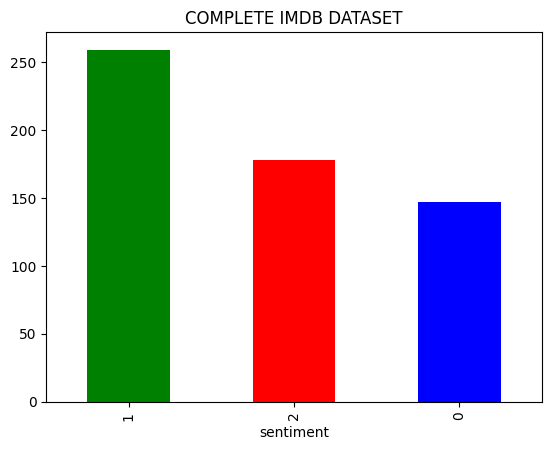

In [32]:
import matplotlib.pyplot as plt
classes=df['sentiment'].value_counts()
plt.title('COMPLETE IMDB DATASET')
classes.plot(kind='bar',color=['green','red','blue'])

plt.show()



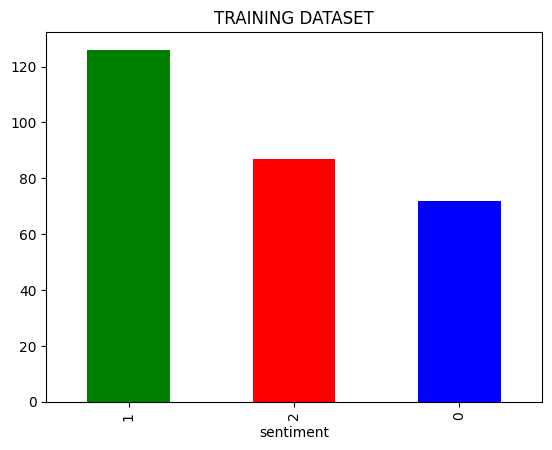

In [33]:
classes=train_df['sentiment'].value_counts()
plt.title('TRAINING DATASET')
classes.plot(kind='bar',color=['green','red','blue'])
plt.show()

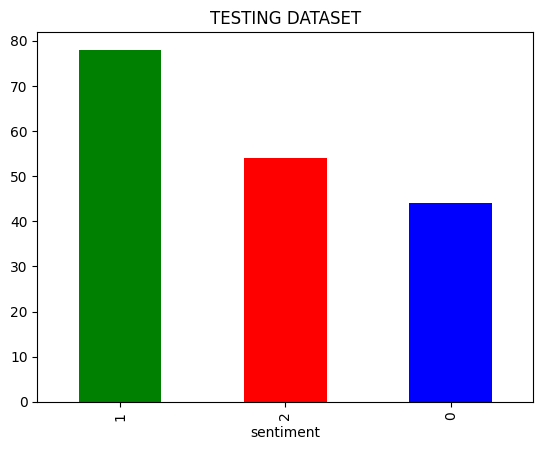

In [34]:
classes=test_df['sentiment'].value_counts()
plt.title('TESTING DATASET')
classes.plot(kind='bar',color=['green','red','blue'])
plt.show()

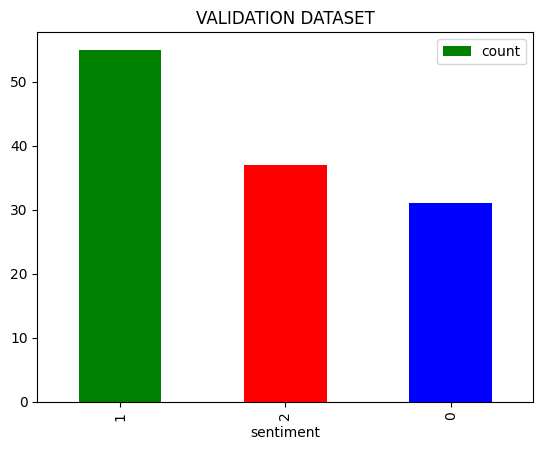

In [35]:
classes=valid_df['sentiment'].value_counts()
plt.title('VALIDATION DATASET')
classes.plot(kind='bar',color=['green','red','blue'])
plt.legend()
plt.show()

**USING TEXT VECTORIZOR**

TF-IDF stands for Term Frequency-Inverse Document Frequency.
TF-IDF is used to convert text data into numerical features that can be fed into a machine learning model.
For sentiment analysis, we fit the features into the vectorizor

In [36]:


vectorizer = TfidfVectorizer(max_features=581, tokenizer=lambda x: re.findall(r'\b\w+\b', x.lower()))
vectorizer.fit(train_df['review'])


c:\Users\awans\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\feature_extraction\text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


TfidfVectorizer(max_features=581,
                tokenizer=<function <lambda> at 0x0000013E1E9DFBA0>)

**INSTANTIATING THE ChatDATASET CLASS**

We create the ChatDATASET Class for our Neural Network. We will instatiate the dataframe and the vectorizer in the constructor. We will use the __len__() method to return length of the dataframe. The __getitem__() method will be used to return the columns transformed as  tensors for our Recurrent Neural Network

In [37]:

class ChatDataset(Dataset):
    def __init__(self, df, vectorizer):
        self.df = df
        self.vectorizer = vectorizer

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        text = self.df.iloc[idx]['review']
        label = self.df.iloc[idx]['sentiment']
        features = self.vectorizer.transform([text]).toarray().squeeze()
        return {'text': torch.tensor(features, dtype=torch.float), 'label': torch.tensor(label, dtype=torch.long)}


**Instantiating the DataLoaders**

In [38]:

train_dataset = ChatDataset(train_df, vectorizer)
test_dataset = ChatDataset(test_df, vectorizer)
valid_dataset=ChatDataset(valid_df, vectorizer)



train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)
valid_loader=DataLoader(valid_dataset, batch_size=2, shuffle=True)


**WRITING THE RNN CLASS**

We will use the LSTM architecture for our multi output classifier. LSTM stands for Long Short Term Memory. It works better than a simple RNN for capturing complex patterns



In [39]:
print("Number of features in vectorizer:", len(vectorizer.get_feature_names_out()))

Number of features in vectorizer: 380


In [40]:

class RNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(RNN, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=1, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        _,(hidden,_)=self.lstm(x)
        output=self.fc(hidden.squeeze(0))
        return output

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = RNN(input_dim=380, hidden_dim=128, output_dim=3).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

**EVALUATING THE MODEL**

In [41]:
def evaluate(loader,criterion):
    model.eval()
    total=0
    with torch.no_grad():
        for batch in loader:
            text=batch['text'].to(device).unsqueeze(1)
            label=batch['label'].to(device)

            output=model(text)
            _,predict=torch.max(output,1)
            
            loss=criterion(output,label)
            total+=loss.item()

    avg=total/len(loader)
    return avg

**MODEL EVALUATION**

In [42]:
from sklearn import metrics
def model_eval(loader):
    model.eval()
    pred=[]
    lab=[]
    with torch.no_grad():
        correct = 0
        total = 0
        for batch in loader:
            text = batch['text'].to(device).unsqueeze(1)  
            labels = batch['label'].to(device)
        
            outputs = model(text)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
            pred.extend(predicted.cpu().numpy())
            lab.extend(labels.cpu().numpy())

        accuracy = correct / total
        print(f'Accuracy: {accuracy * 100}%')

    return pred,lab

**TRAINING THE MODEL**

In [43]:

for epoch in range(5):
    model.train()
    total_loss = 0
    for batch in train_loader:
        text = batch['text'].to(device).unsqueeze(1) 
        labels = batch['label'].to(device)
        
        optimizer.zero_grad()
        outputs = model(text)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    avg_test_loss = total_loss / len(test_loader)
    avg_valid_loss=evaluate(valid_loader,criterion)
    print(f'Epoch {epoch + 1},Testing Loss: {avg_test_loss}, Validation Loss:{avg_valid_loss}, ')


Epoch 1,Testing Loss: 1.7596455988558857, Validation Loss:1.0529504697169028, 
Epoch 2,Testing Loss: 1.6164518608288332, Validation Loss:0.9591254702498836, 
Epoch 3,Testing Loss: 1.2542338537221605, Validation Loss:0.7728932814732674, 
Epoch 4,Testing Loss: 0.7031038020398807, Validation Loss:0.6328823612101616, 
Epoch 5,Testing Loss: 0.3379414990671318, Validation Loss:0.6139297830241341, 


**MODEL ACCURACY**

In [49]:
_,_=model_eval(train_loader)

Accuracy: 99.29824561403508%


In [50]:
_,_=model_eval(test_loader)

Accuracy: 79.54545454545455%


In [51]:
_,_=model_eval(valid_loader)

Accuracy: 71.54471544715447%


**CONFUSION MATRIX OF TESTING DATASET**

Accuracy: 79.54545454545455%


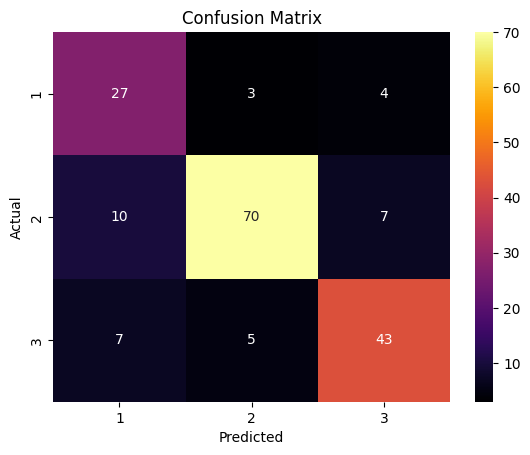

In [47]:
import seaborn as sns
def plot_confusion_matrix(true, pred, class_names):
    cm = confusion_matrix(true, pred)
    sns.heatmap(cm, annot=True, cmap='inferno', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

true_labels, pred_labels = model_eval(test_loader)
class_names = [1,2,3]  
plot_confusion_matrix(true_labels, pred_labels, class_names)

**CONFUSION MATRIX OF VALIDATION DATA**

Accuracy: 71.54471544715447%


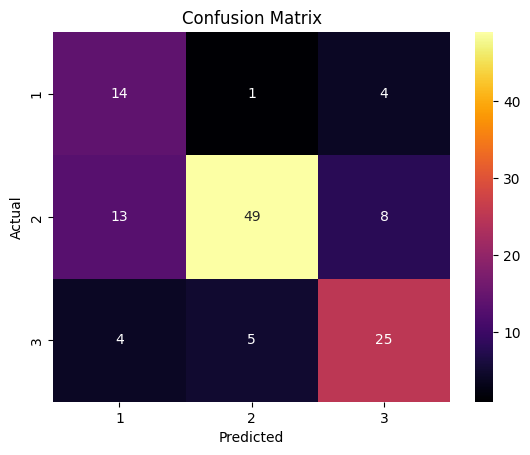

In [48]:
true_labels, pred_labels = model_eval(valid_loader)
class_names = [1,2,3]  
plot_confusion_matrix(true_labels, pred_labels, class_names)

**CONCLUSION**

We have successfully trained the model on the Chat Messages Sentiment Dataset. The validation accuracy is 77% and testing accuracy is 78%. 